In [1]:
import torch, detectron2
# import tqdm as notebook_tqdm
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

/userhome/cs2/u3572156/exit/envs/fyp/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/bin/bash: nvcc: command not found
torch:  1.12 ; cuda:  1.12.1
detectron2: 0.6


In [2]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from matplotlib import pyplot as plt


# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

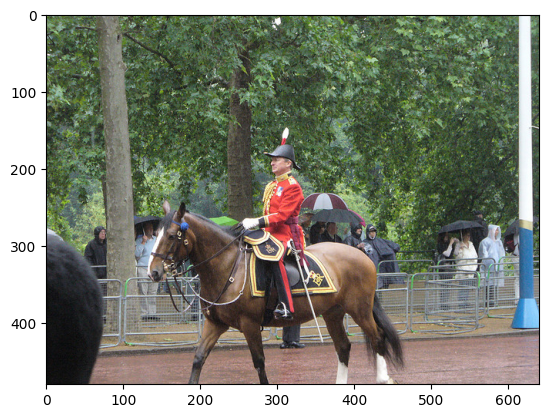

In [3]:
!wget http://images.cocodataset.org/val2017/000000439715.jpg -q -O input.jpg
im = cv2.imread("input.jpg")
im2 = im[:,:,::-1]
# OpenCV stores images in BGR order instead of RGB
plt.imshow(im2)
plt.show()
# cv2.imshow("image",im)

In [4]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

[03/11 14:03:06 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


/userhome/cs2/u3572156/exit/envs/fyp/lib/python3.10/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484808560/work/aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


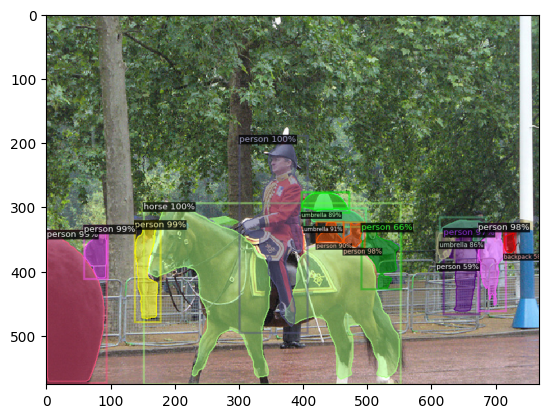

In [5]:
# We can use `Visualizer` to draw the predictions on the image.
# print( MetadataCatalog.get(cfg.DATASETS.TRAIN[0]))
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.imshow(out.get_image())
plt.show()

[03/11 14:21:14 d2.data.datasets.lvis]: Loaded 944 images in the LVIS format from lvis_v1_small.json


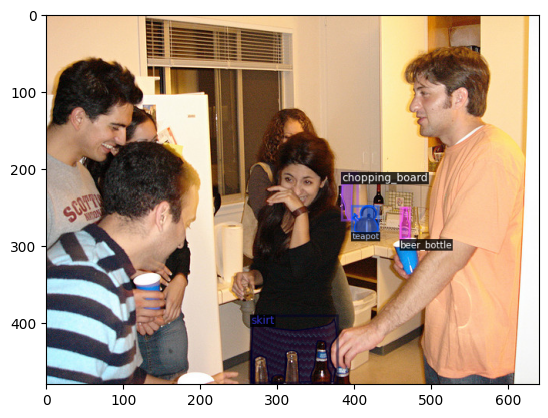

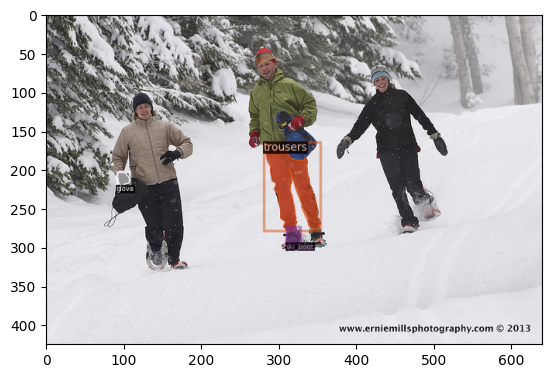

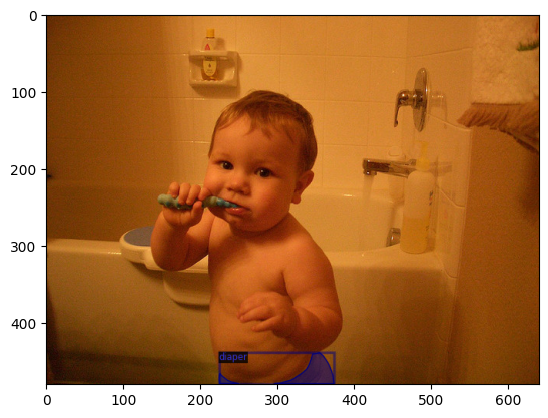

In [9]:
from detectron2.data.datasets import load_lvis_json,get_lvis_instances_meta

d = load_lvis_json("lvis_v1_small.json","")
# print(d[:10])
meta = get_lvis_instances_meta("v1")
# print(meta.keys())
for a in random.sample(d, 3):
    img = cv2.imread(a["file_name"])
    # OpenCV stores images in BGR order instead of RGB
    im2 = img[:,:,::-1]
    visualizer = Visualizer(im2, metadata=meta, scale=1)
    out = visualizer.draw_dataset_dict(a)
    plt.imshow(out.get_image())
    plt.show()

In [6]:
from detectron2.data.datasets import register_lvis_instances
register_lvis_instances("lvis_dataset_smalltest_v1", {}, "lvis_v1_small.json", "")


1. visualize LVIS dataset (from ballon dataset) done
2. cocofied LVIS -> finetune 
3. Tensorboard log vairables meaning & code 
-  writer = SummaryWriter("path")
-  writer.to_scalar("Var Name", val, X_coord)


In [7]:
# from detectron2.engine import DefaultTrainer

# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
# torch.backends.cudnn.benchmark = True

# cfg = get_cfg()
# cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
# cfg.DATASETS.TRAIN = ("lvis_dataset_smalltest_v1",)
# cfg.DATASETS.TEST = ()
# cfg.DATALOADER.NUM_WORKERS = 2
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
# cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
# cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
# cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
# cfg.SOLVER.STEPS = []        # do not decay learning rate
# cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
# cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# # NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

# os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
# trainer = DefaultTrainer(cfg) 
# trainer.resume_or_load(resume=False)
# trainer.train()

[03/11 14:03:21 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[03/11 14:03:23] fvcore.common.checkpoint WARNING: Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
[03/11 14:03:23] fvcore.common.checkpoint WARNING: Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
[03/11 14:03:23] fvcore.common.checkpoint WARNING: Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
[03/11 14:03:23] fvcore.common.checkpoint WARNING: Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You mi

[03/11 14:03:23 d2.engine.train_loop]: Starting training from iteration 0


/opt/conda/conda-bld/pytorch_1659484808560/work/aten/src/ATen/native/cuda/Loss.cu:271: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [0,0,0] Assertion `t >= 0 && t < n_classes` failed.
/opt/conda/conda-bld/pytorch_1659484808560/work/aten/src/ATen/native/cuda/Loss.cu:271: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [1,0,0] Assertion `t >= 0 && t < n_classes` failed.
/opt/conda/conda-bld/pytorch_1659484808560/work/aten/src/ATen/native/cuda/Loss.cu:271: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [2,0,0] Assertion `t >= 0 && t < n_classes` failed.
/opt/conda/conda-bld/pytorch_1659484808560/work/aten/src/ATen/native/cuda/Loss.cu:271: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [3,0,0] Assertion `t >= 0 && t < n_classes` failed.
/opt/conda/conda-bld/pytorch_1659484808560/work/aten/src/ATen/native/cuda/Loss.cu:271: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [4,0,0] Assertion `t >= 0 && t < n_cl

ERROR [03/11 14:03:26 d2.engine.train_loop]: Exception during training:
Traceback (most recent call last):
  File "/userhome/cs2/u3572156/fyp/detectron2/detectron2/engine/train_loop.py", line 149, in train
    self.run_step()
  File "/userhome/cs2/u3572156/fyp/detectron2/detectron2/engine/defaults.py", line 494, in run_step
    self._trainer.run_step()
  File "/userhome/cs2/u3572156/fyp/detectron2/detectron2/engine/train_loop.py", line 277, in run_step
    loss_dict = self.model(data)
  File "/userhome/cs2/u3572156/exit/envs/fyp/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1130, in _call_impl
    return forward_call(*input, **kwargs)
  File "/userhome/cs2/u3572156/fyp/detectron2/detectron2/modeling/meta_arch/rcnn.py", line 167, in forward
    _, detector_losses = self.roi_heads(images, features, proposals, gt_instances)
  File "/userhome/cs2/u3572156/exit/envs/fyp/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1130, in _call_impl
    return forward_cal

RuntimeError: CUDA error: device-side assert triggered

In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output